# LSTM: POS-Tagging

Небольшая реккурентная сеть, которая решает задачу частеречной разметки предложения.

В качестве датасета, на котором производится обучения используется **SynTagRus**. Чуть подробнее узнать о корпусе можно [здесь](https://universaldependencies.org/treebanks/ru_syntagrus/index.html).

## Библиотеки

In [0]:
!pip install pyconll

In [0]:
import time
from datetime import timedelta

import pyconll
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)
from collections import Counter

## Датасет

Скачаем датасет и преобразуем его в удобную для работы форму.

In [0]:
!mkdir syntagrus
!wget -O 'syntagrus/ru_syntagrus-ud-train.conllu' https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
!wget -O 'syntagrus/ru_syntagrus-ud-dev.conllu' https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

In [0]:
full_train = pyconll.load_from_file('/content/syntagrus/ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('/content/syntagrus/ru_syntagrus-ud-dev.conllu')

Преобразуем данные из разметки CoNLL в удобную нам форму в виде списка кортежей. Каждый кортеж будет содержать текст и POS-теги.

In [0]:
training_data = []

for sent in full_train:
    words = []
    labels = []
    for token in sent:
        words.append(token.form)
        labels.append(token.upos)
    training_data.append((words, labels))

test_data = []

for sent in full_test:
    words = []
    labels = []
    for token in sent:
        words.append(token.form)
        labels.append(token.upos)
    test_data.append((words, labels))

Примеры текстов:

In [7]:
training_data[0]

(['Анкета', '.'], ['NOUN', 'PUNCT'])

In [8]:
print(test_data[0])

(['Алгоритм', ',', 'от', 'имени', 'учёного', 'аль', '-', 'Хорезми', ',', '-', 'точный', 'набор', 'инструкций', ',', 'описывающих', 'порядок', 'действий', 'исполнителя', 'для', 'достижения', 'результата', 'решения', 'задачи', 'за', 'конечное', 'время', '.'], ['NOUN', 'PUNCT', 'ADP', 'NOUN', 'NOUN', 'PART', 'PUNCT', 'PROPN', 'PUNCT', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT'])


Два метода, которые будут преобразовывать наши текстовые последовательности в индексы. (Можно было бы воспользоваться и одним методом, т.к. их функционал аналогичен - возвращает индекс токена), но в датасете той версии, которую я скачал, имеется небольшая ошибка, поэтому пришлось прибегнуть к такому ухищрению.

На вход метода подаётся последовательность в виде списка токенов, а также словарь (токен и его идентификатор), выход - последовательность в виде индексов.

In [0]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return idxs

def prepare_labels(seq, to_ix):
    idxs = []
    for w in seq:
        if w is None:
            w = 'NOUN'
        idxs.append(to_ix[w])
    return idxs

Создадим словари индексов для слов датасета и для меток.

In [0]:
word2id = {'<PAD>': 0}
for sent, tags in training_data:
    for word in sent:
        if word not in word2id:
            word2id[word] = len(word2id)
for sent, tags in test_data:
    for word in sent:
        if word not in word2id:
            word2id[word] = len(word2id)

In [0]:
UNIQUE_TAGS = ['<NOTAG>'] + sorted({token.upos for sent in full_train for token in sent if token.upos})
label2id = {label: i for i, label in enumerate(UNIQUE_TAGS)}

Теперь преобразуем наш датасет. Переведём все токены и метки в их индексы, полученные массивы расширим паддингами до единого размера, а затем приведём их к типу `torch.tensor`.

In [0]:
train_seq, train_lengths, train_label = [], [], []

for tokens, labels in training_data:
    t = prepare_sequence(tokens, word2id)
    l = prepare_labels(labels, label2id)
    train_seq.append(t)
    train_lengths.append(len(t))
    train_label.append(l)

assert len(train_seq) == len(train_lengths) == len(train_label)

In [0]:
test_seq, test_lengths, test_label = [], [], []

for tokens, labels in test_data:
    t = prepare_sequence(tokens, word2id)
    l = prepare_labels(labels, label2id)
    test_seq.append(t)
    test_lengths.append(len(t))
    test_label.append(l)

assert len(test_seq) == len(test_lengths) == len(test_label)

Узнаем максимальные размеры наших последовательностей для того, чтобы знать, какой размер входящих данных использовать:

In [14]:
max(train_lengths), max(test_lengths)

(205, 144)

Возьмём максимальный размер последовательности равный `205`, а все остальные последовательности нашего датасета расширим паддингами.

In [0]:
train_seq = pad_sequences(
    train_seq,
    maxlen=205,
    dtype='long',
    truncating='post',
    padding='post'
)
train_label = pad_sequences(
    train_label,
    maxlen=205,
    dtype='long',
    truncating='post',
    padding='post'
)

test_seq = pad_sequences(
    test_seq,
    maxlen=205,
    dtype='long',
    truncating='post',
    padding='post'
)
test_label = pad_sequences(
    test_label,
    maxlen=205,
    dtype='long',
    truncating='post',
    padding='post'
)

Посмотрим, какие у нас теперь получились последовательности

In [16]:
print(train_seq[0])
print()
print(train_label[0])

[1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[ 8 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [0]:
train_seq = torch.tensor(train_seq, dtype=torch.long)
train_label = torch.tensor(train_label, dtype=torch.long)
test_seq = torch.tensor(test_seq, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)

# Подготовка к обучению

## Модель

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 hidden_size, 
                 num_layers, 
                 vocab_size, 
                 embedding_size, 
                 batch_size,
                 dropout):
        super(LSTMTagger, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.batch_size = batch_size

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)

        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        # dim: batch_size x sent_max_len x embedding_dim
        x = self.embedding(x)
        # dim: batch_size x sent_max_len x lstm_hidden_dim
        x, _ = self.lstm(x)
        #dim: batch_size*sent_max_len x lstm_hidden_dim
        x = x.reshape(-1, x.shape[2])
        x = self.fc(x)
        # dim: batch_size*sent_max_len x num_tags
        x = F.log_softmax(x, dim=1)
        return x

## CPU / GPU

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla P100-PCIE-16GB


## Параметры

In [0]:
BATCH_SIZE = 128
EPOCHS = 2
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = .2
EMBEDDING_SIZE = 300
LEARNING_RATE = .001

## Инициализация загрузчиков данных

Для подачи батчей нейросети воспользуемся стандартным загрузчиком `DataLoader`. При этом данные будем случайным образом сэмплитовать.

In [0]:
train = TensorDataset(train_seq, train_label)
test = TensorDataset(test_seq, test_label)
train_dataloader = DataLoader(
    train,
    sampler=RandomSampler(train),
    batch_size=BATCH_SIZE
)
test_dataloader = DataLoader(
    test,
    sampler=RandomSampler(test),
    batch_size=BATCH_SIZE
)

## Инициализация модели, оптимизатора и функции потерь

In [0]:
model = LSTMTagger(
    # Этот параметр должен соответствовать размеру сэмпла
    input_size=max(train_lengths),
    # Равен количеству меток
    output_size=len(label2id),
    hidden_size=LSTM_HIDDEN_SIZE,
    num_layers=LSTM_NUM_LAYERS,
    # Размер словаря, нужен для эмбеддинга
    vocab_size=len(word2id),
    embedding_size=EMBEDDING_SIZE,
    batch_size=BATCH_SIZE,
    dropout=LSTM_DROPOUT
)
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

## Взвешеная функция потерь

Распределение меток нашего датасета не является сбалансированным, кроме того, мы используем паддинги. Всё это будет влиять на процесс обучения и оценку качества нашей модели. Поэтому будем использовать взвешенные параметры для каждой метки, чтобы произвести более сбалансированное обучение.

In [23]:
label_counter = Counter()

for labels in train_label.numpy():
    for label in labels:
        label_counter[label] += 1
        
label_counter.most_common()

[(0, 9135344),
 (8, 215544),
 (13, 157989),
 (16, 97670),
 (1, 85589),
 (2, 81963),
 (3, 44101),
 (11, 38438),
 (12, 32401),
 (5, 30432),
 (10, 26651),
 (6, 21968),
 (14, 16219),
 (9, 13746),
 (4, 7522),
 (15, 840),
 (17, 375),
 (7, 78)]

In [0]:
label_weights = torch.ones(len(label_counter)).to(device)
label_divs = torch.ones(len(label_counter)).to(device)

for tag, inv_weight in label_counter.most_common():
    label_divs[tag] = inv_weight

norm = torch.norm(label_divs, p=2, dim=0).detach()
label_divs = label_divs.div(norm.expand_as(label_divs))

label_weights /= label_divs

Теперь у нас для каждой метки имеется вес:

In [25]:
print(label_weights.detach())

tensor([1.0006e+00, 1.0680e+02, 1.1153e+02, 2.0727e+02, 1.2152e+03, 3.0037e+02,
        4.1610e+02, 1.1719e+05, 4.2409e+01, 6.6499e+02, 3.4299e+02, 2.3781e+02,
        2.8212e+02, 5.7858e+01, 5.6359e+02, 1.0882e+04, 9.3590e+01, 2.4376e+04],
       device='cuda:0')


In [0]:
criterion = nn.CrossEntropyLoss(weight=label_weights)

Архитектура нашей модели:

In [27]:
print(model)

LSTMTagger(
  (embedding): Embedding(117012, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=18, bias=True)
)


Количество параметров модели:

In [28]:
print(f'{sum(np.product(t.shape) for t in model.parameters()):,}')

35,458,178


## Обучение

In [29]:
model.to(device)
train_losses = []
test_losses = []
train_start = time.monotonic()
for epoch in range(1, EPOCHS+1):
    # Используем такой метод для получения отметки времени, чтобы не было
    # проблем с timedelta 
    epoch_start = time.monotonic()
    model.train()
    mean_train_loss = 0
    
    for i, (seq_tensor, label) in enumerate(train_dataloader):
        # Обнулим градиенты
        optimizer.zero_grad()
        # Переведём наш батч на выбранное устройство
        seq_tensor = seq_tensor.to(device)
        label = label.to(device)

        # Получим результат после прямого прогона
        output = model(seq_tensor)

        # Функция потерь
        loss = criterion(output, label.view(-1))
        train_losses.append(loss.item())
        mean_train_loss += loss.item()

        # обратное распространение ошибки
        loss.backward()
        optimizer.step()
    mean_train_loss /= i

    # проверим модель на тестовых данных
    mean_test_loss = 0
    model.eval()
    with torch.no_grad():        
        for i, (seq_tensor, label) in enumerate(test_dataloader):
            seq_tensor = seq_tensor.to(device)
            label = label.to(device)

            output = model(seq_tensor)

            loss = criterion(output, label.view(-1))
            test_losses.append(loss.item())
            mean_test_loss += loss.item()
    mean_test_loss /= i

    # Results
    print(f'Эпоха {epoch}')
    print(f'Время эпохи: {timedelta(seconds=time.monotonic() - epoch_start)}')
    print(f'Общее время обучения: {timedelta(seconds=time.monotonic() - train_start)}')
    print(f'Средний лосс на обучении:', mean_train_loss)
    print(f'Средний лосс на тесте:', mean_test_loss)
    print('')

Эпоха 1
Время эпохи: 0:00:17.367222
Общее время обучения: 0:00:17.367540
Средний лосс на обучении: 1.2415809230854504
Средний лосс на тесте: 0.8638946600988799

Эпоха 2
Время эпохи: 0:00:17.104209
Общее время обучения: 0:00:34.472236
Средний лосс на обучении: 0.516047059746552
Средний лосс на тесте: 0.6768655256897795



## Динамика обучения

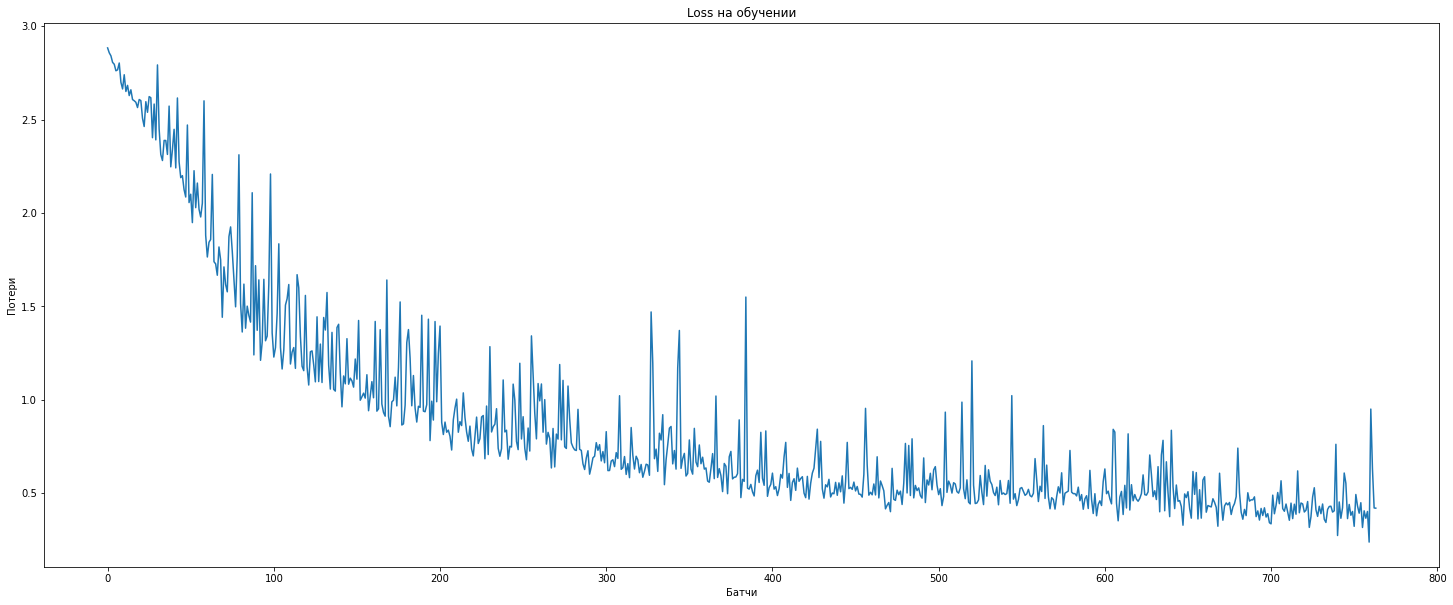

In [30]:
plt.figure(figsize=(25, 10))
plt.plot(train_losses)
#plt.plot(test_losses)
plt.title('Loss на обучении')
plt.xlabel('Батчи')
plt.ylabel('Потери')
plt.show()

## Посмотрим, как предсказывает модель

In [0]:
id2label = dict(map(reversed, label2id.items()))

In [71]:
model.eval()

sentence, true_labels = training_data[222]
s_ids = prepare_sequence(sentence, word2id)

s_ids = torch.tensor([s_ids], dtype=torch.long).to(device)
with torch.no_grad():
    output = model(s_ids)
logits = output.detach().cpu().numpy()
predicted = np.argmax(logits, axis=1)
predicted = [id2label[id] for id in predicted]

print ("{:<20} {:<10} {:<10}".format('Токен', 'Истинная', 'Предсказанная'))
print ("{:<20} {:<10} {:<10}".format('-----', '--------', '-------------'))
for t, t_l, p_l in zip(sentence, true_labels, predicted):
    print ("{:<20} {:<10} {:<10}".format(t, t_l, p_l))

Токен                Истинная   Предсказанная
-----                --------   -------------
Единственная         ADJ        ADJ       
возможность          NOUN       NOUN      
-                    PUNCT      PUNCT     
снять                VERB       VERB      
частную              ADJ        VERB      
квартиру             NOUN       NOUN      
.                    PUNCT      PUNCT     
